# Goals

train.csv and test.csv contain a subset of attributes from impression logs for an online advertising campaign.
Compute the probabilities of a "1" label for each row in test.csv

The output should be a file containing a column of numbers with probabilities of a response for every row of the test csv.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159996 entries, 0 to 159995
Data columns (total 16 columns):
placement       159996 non-null int64
position        159996 non-null int64
browser         159996 non-null int64
carrier         159996 non-null int64
domain          139304 non-null object
supply_type     159996 non-null int64
language        159996 non-null int64
region          159996 non-null int64
os_extended     159996 non-null int64
publisher       159996 non-null int64
device_model    159996 non-null int64
device_type     159996 non-null object
user_day        159996 non-null int64
user_hour       159996 non-null int64
size            159996 non-null object
response        159996 non-null int64
dtypes: int64(13), object(3)
memory usage: 19.5+ MB


## Data Cleaning, Transformation and Exploration

There are some null values in the domain field. We could impute these using the most frequent values but this may not be treating the data correctly. In these circumstances, it is better to create a new "Unknown_Domain" category in order to treat the missing field as a separate category on its own.

In [3]:
df.loc[df.domain.isnull(), 'domain'] = 'Unknown_Domain'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159996 entries, 0 to 159995
Data columns (total 16 columns):
placement       159996 non-null int64
position        159996 non-null int64
browser         159996 non-null int64
carrier         159996 non-null int64
domain          159996 non-null object
supply_type     159996 non-null int64
language        159996 non-null int64
region          159996 non-null int64
os_extended     159996 non-null int64
publisher       159996 non-null int64
device_model    159996 non-null int64
device_type     159996 non-null object
user_day        159996 non-null int64
user_hour       159996 non-null int64
size            159996 non-null object
response        159996 non-null int64
dtypes: int64(13), object(3)
memory usage: 19.5+ MB


In [4]:
df.head()

,placement,position,browser,carrier,domain,supply_type,language,region,os_extended,publisher,device_model,device_type,user_day,user_hour,size,response
0,6360701,0,18,283,dramacity.se,1,1,0,137,633687,0,pc & other devices,2,14,300x250,0
1,6360701,0,8,1,dramacity.se,1,1,0,92,633687,0,pc & other devices,6,13,300x250,0
2,6360701,0,8,1,kissasian.com,1,1,0,141,633687,11995,phone,4,11,300x250,0
3,6360701,0,9,1,icdrama.se,1,2,0,80,633687,300,tablet,2,11,300x250,0
4,6360701,0,21,1,kissasian.com,1,1,0,155,633687,0,pc & other devices,6,11,300x250,0


In [5]:
# Checking number of unique vales in each category for data pre-processing
tempdf = df.copy()
data = ['placement', 'position', 
                'browser', 'carrier', 'supply_type', 'language', 
                'region', 'os_extended', 'publisher', 'device_model']
tempdf[data] = tempdf[data].apply(lambda x: x.astype('category'))


In [6]:
tempdf.describe(include='all')

,placement,position,browser,carrier,domain,supply_type,language,region,os_extended,publisher,device_model,device_type,user_day,user_hour,size,response
count,159996.0,159996.0,159996.0,159996.0,159996,159996.0,159996.0,159996.0,159996.0,159996.0,159996.0,159996,159996.000000,159996.000000,159996,159996.000000
unique,4187.0,3.0,25.0,5.0,2699,3.0,33.0,5.0,94.0,823.0,478.0,6,NaN,NaN,5,NaN
top,6360701.0,0.0,8.0,1.0,kissasian.com,1.0,1.0,0.0,156.0,633687.0,0.0,pc & other devices,NaN,NaN,300x250,NaN
freq,41315.0,139583.0,90367.0,127984.0,37601,96765.0,145598.0,153266.0,26131.0,78391.0,98894.0,98894,NaN,NaN,77629,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.963937,10.545064,NaN,0.004538
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.988903,4.608191,NaN,0.067209
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,8.000000,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,11.000000,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,14.000000,NaN,0.000000


## Visualizing the Data

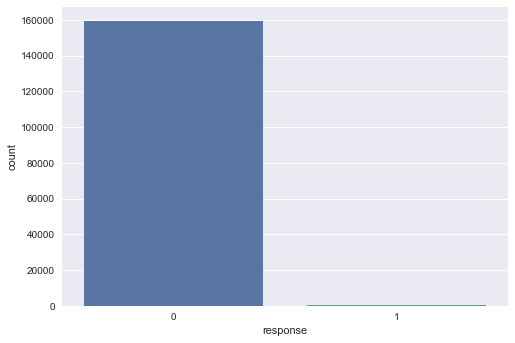

In [7]:
sns.set()
sns.countplot(x="response", data=df)

The linear scale on the plot above is not very informative. We can change the scale to log scale to be able to better distinguish between the features of interest and the response classification.

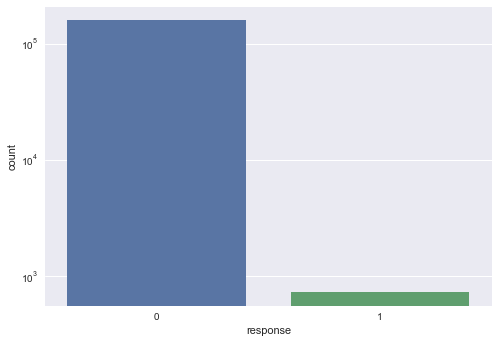

In [8]:
sns.set()
sns.countplot(x="response", data=df).set_yscale('log')

From the plot above, we can see there is a large class imbalance for the positive response.

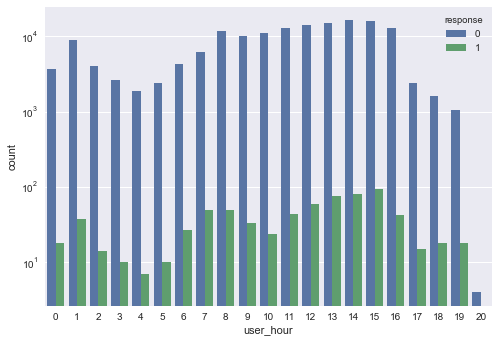

In [9]:
sns.countplot(x="user_hour", hue="response", data=df).set_yscale('log')

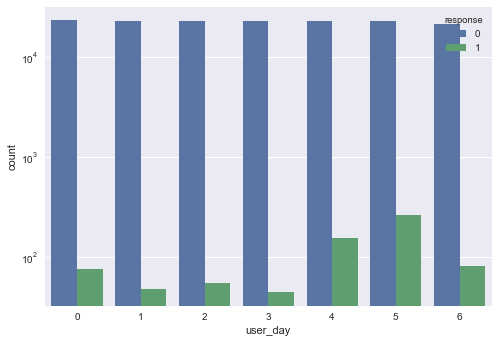

In [10]:
sns.countplot(x="user_day", hue="response", data=df).set_yscale('log')

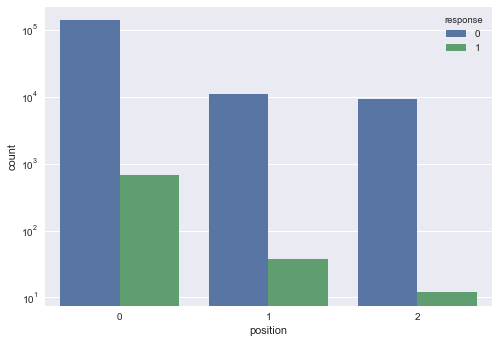

In [11]:
sns.countplot(x="position", hue="response", data=df).set_yscale('log')

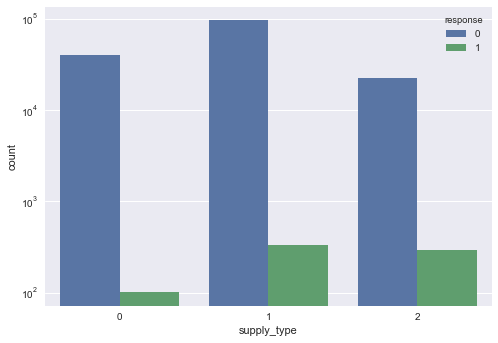

In [12]:
sns.countplot(x="supply_type", hue="response", data=df).set_yscale('log')

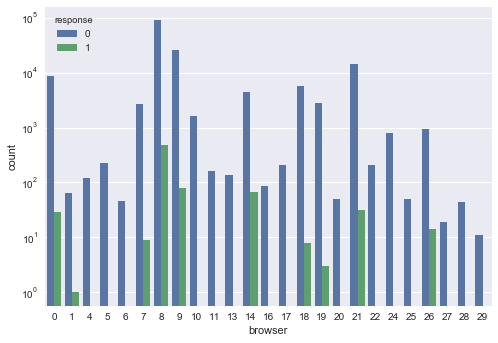

In [13]:
sns.countplot(x="browser", hue="response", data=df).set_yscale('log')

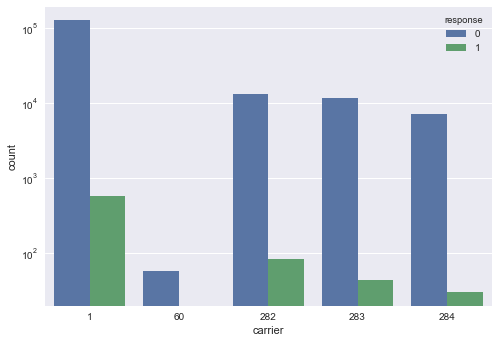

In [14]:
sns.countplot(x="carrier", hue="response", data=df).set_yscale('log')

# Data Transformation 

Create ordinal encoding for categorical variables to prepare the data before it can be run through any models.

In [15]:
# Use sklearn LabelEncoder for ordinal encoding for select columns
labelcols = ['placement', 'browser', 'domain', 'language', 'os_extended', 'publisher', 'device_model', 'user_hour']
le = preprocessing.LabelEncoder()
df[labelcols] = df[labelcols].apply(le.fit_transform)

In [16]:
df.head()

,placement,position,browser,carrier,domain,supply_type,language,region,os_extended,publisher,device_model,device_type,user_day,user_hour,size,response
0,644,0,14,283,667,1,1,0,65,221,0,pc & other devices,2,14,300x250,0
1,644,0,6,1,667,1,1,0,45,221,0,pc & other devices,6,13,300x250,0
2,644,0,6,1,1300,1,1,0,69,221,189,phone,4,11,300x250,0
3,644,0,7,1,1145,1,2,0,37,221,5,tablet,2,11,300x250,0
4,644,0,17,1,1300,1,1,0,80,221,0,pc & other devices,6,11,300x250,0


In [17]:
data = ['position', 'carrier', 'supply_type',  
                'region', 'user_day']
df[data] = df[data].apply(lambda x: x.astype('category'))

Create one-hot-encoding for select columns

In [18]:
# Use one-hot-encoding for select columns
# In particular avoiding columns with a large number of distinct categories such as placement

pdOHEcols = ['position', 'carrier', 'supply_type', 'region', 'user_day','device_type', 'size']
print("Original Features", list(df.columns), "\n")
data = df[pdOHEcols]
data_dummies = pd.get_dummies(data, drop_first = True)
print("One hot encoded features after get_dummies: \n", list(data_dummies.columns))

Original Features ['placement', 'position', 'browser', 'carrier', 'domain', 'supply_type', 'language', 'region', 'os_extended', 'publisher', 'device_model', 'device_type', 'user_day', 'user_hour', 'size', 'response'] 

One hot encoded features after get_dummies: 
 ['position_1', 'position_2', 'carrier_60', 'carrier_282', 'carrier_283', 'carrier_284', 'supply_type_1', 'supply_type_2', 'region_1', 'region_2', 'region_4', 'region_5', 'user_day_1', 'user_day_2', 'user_day_3', 'user_day_4', 'user_day_5', 'user_day_6', 'device_type_pc & other devices', 'device_type_phone', 'device_type_set top box', 'device_type_tablet', 'device_type_tv', 'size_300x250', 'size_300x600', 'size_320x50', 'size_728x90']


Combine dummies dataframe with original data

In [19]:
data = df[labelcols].join(data_dummies.ix[:,:])

In [20]:
data['response'] = df['response']

In [21]:
pd.options.display.max_columns = 999
data.head()

,placement,browser,domain,language,os_extended,publisher,device_model,user_hour,position_1,position_2,carrier_60,carrier_282,carrier_283,carrier_284,supply_type_1,supply_type_2,region_1,region_2,region_4,region_5,user_day_1,user_day_2,user_day_3,user_day_4,user_day_5,user_day_6,device_type_pc & other devices,device_type_phone,device_type_set top box,device_type_tablet,device_type_tv,size_300x250,size_300x600,size_320x50,size_728x90,response
0,644,14,667,1,65,221,0,14,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,644,6,667,1,45,221,0,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
2,644,6,1300,1,69,221,189,11,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
3,644,7,1145,2,37,221,5,11,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4,644,17,1300,1,80,221,0,11,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0


In [22]:
df = data.copy()

In [23]:
# Add frequency of occurence as a feature
for col in ['placement', 'domain', 'browser', 'language', 'os_extended', 'publisher', 'device_model']:
    df[col + 'freq'] = df.groupby(col)[col].transform('count')

In [24]:
# reorder columns for convience
df['target'] = df['response']
df.drop('response', axis = 1, inplace=True)
df.rename(columns={'target': 'response'}, inplace=True)
df.head()

,placement,browser,domain,language,os_extended,publisher,device_model,user_hour,position_1,position_2,carrier_60,carrier_282,carrier_283,carrier_284,supply_type_1,supply_type_2,region_1,region_2,region_4,region_5,user_day_1,user_day_2,user_day_3,user_day_4,user_day_5,user_day_6,device_type_pc & other devices,device_type_phone,device_type_set top box,device_type_tablet,device_type_tv,size_300x250,size_300x600,size_320x50,size_728x90,placementfreq,domainfreq,browserfreq,languagefreq,os_extendedfreq,publisherfreq,device_modelfreq,response
0,644,14,667,1,65,221,0,14,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,41315,14134,5757,145598,12572,78391,98894,0
1,644,6,667,1,45,221,0,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,41315,14134,90367,145598,14260,78391,98894,0
2,644,6,1300,1,69,221,189,11,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,41315,37601,90367,145598,10801,78391,38,0
3,644,7,1145,2,37,221,5,11,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,41315,10212,25631,8701,274,78391,9966,0
4,644,17,1300,1,80,221,0,11,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,41315,37601,14725,145598,22608,78391,98894,0


In [25]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    

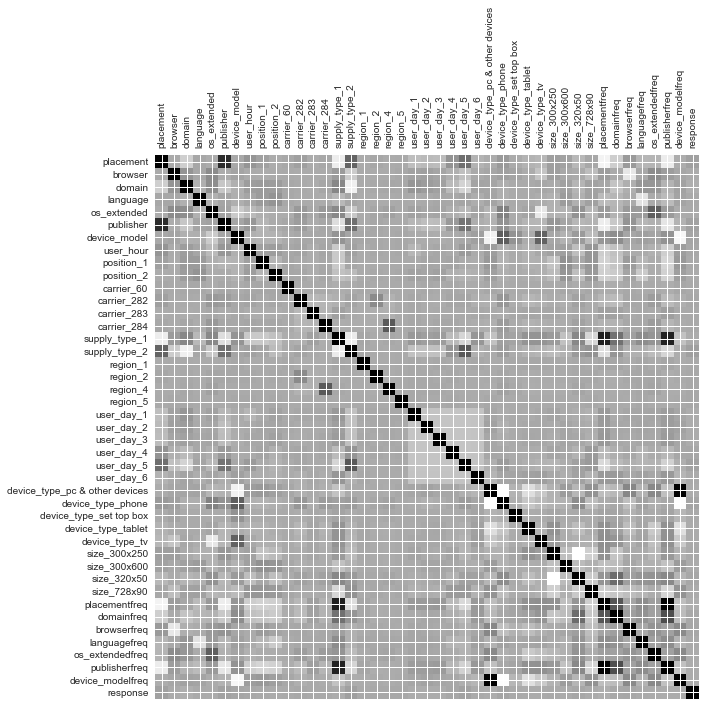

In [26]:
"""Plot the correlation matrix to examine correlations between each pair of features and the target Result.

"""
to_corr = df[df.columns]

plot_corr(to_corr)


Plotting the correlation matrix on the one-hot-encoded features shows:
  1. No single feature is strongly correlated with response (the complete list of correlations to response is below)
  2. There is significant correlation between certain features. For example placement is highly correlated with publisher. Supply type is highly correlated with publisher frequency and placement frequency.

In [27]:
corr_data = to_corr.corr()
print(corr_data['response'].sort_values(ascending=True))

placementfreq                    -0.027638
domain                           -0.026955
supply_type_1                    -0.020179
publisherfreq                    -0.018023
device_modelfreq                 -0.016556
user_day_3                       -0.015822
user_day_1                       -0.014769
device_type_pc & other devices   -0.014689
user_day_2                       -0.013024
os_extendedfreq                  -0.012209
position_2                       -0.012158
os_extended                      -0.010520
device_type_tv                   -0.007869
size_728x90                      -0.007674
device_type_tablet               -0.007488
size_300x600                     -0.007127
browser                          -0.006973
position_1                       -0.004721
user_day_6                       -0.004044
device_type_set top box          -0.003197
carrier_283                      -0.003193
language                         -0.003010
languagefreq                     -0.002263
size_300x25

It is clear that most features are only weakly correlated with response. Supply type 2 is the highest positive correlation and placement frequency is the highest negative correlation. 

In [28]:
# We can run feature scaling on the columns
# This doesn't impact categorical features, however is important for numeric features.
scaler1 = preprocessing.StandardScaler()
scaled_features = scaler1.fit_transform(df[df.columns[:-1]].values)
scaled_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns[:-1])
scaled_df['response'] = df['response']

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [29]:
scaled_df.head()

,placement,browser,domain,language,os_extended,publisher,device_model,user_hour,position_1,position_2,carrier_60,carrier_282,carrier_283,carrier_284,supply_type_1,supply_type_2,region_1,region_2,region_4,region_5,user_day_1,user_day_2,user_day_3,user_day_4,user_day_5,user_day_6,device_type_pc & other devices,device_type_phone,device_type_set top box,device_type_tablet,device_type_tv,size_300x250,size_300x600,size_320x50,size_728x90,placementfreq,domainfreq,browserfreq,languagefreq,os_extendedfreq,publisherfreq,device_modelfreq,response
0,-0.565883,1.507299,-0.665701,-0.130800,-0.084639,-0.554683,-0.458714,0.749740,-0.271487,-0.250261,-0.018878,-0.299471,3.566101,-0.215857,0.808362,-0.409055,-0.062169,-0.095132,-0.172475,-0.018878,-0.410781,2.444474,-0.410719,-0.409814,-0.411737,-0.392192,0.786037,-0.609698,-0.047356,-0.300709,-0.153327,1.030065,-0.127517,-0.796616,-0.26794,1.120142,-0.000527,-1.358546,0.314350,-0.204725,1.003876,0.780535,0
1,-0.565883,-0.388579,-0.665701,-0.130800,-1.000039,-0.554683,-0.458714,0.532735,-0.271487,-0.250261,-0.018878,-0.299471,-0.280418,-0.215857,0.808362,-0.409055,-0.062169,-0.095132,-0.172475,-0.018878,-0.410781,-0.409086,-0.410719,-0.409814,-0.411737,2.549772,0.786037,-0.609698,-0.047356,-0.300709,-0.153327,1.030065,-0.127517,-0.796616,-0.26794,1.120142,-0.000527,0.866293,0.314350,-0.002712,1.003876,0.780535,0
2,-0.565883,-0.388579,0.261649,-0.130800,0.098441,-0.554683,0.860832,0.098724,-0.271487,-0.250261,-0.018878,-0.299471,-0.280418,-0.215857,0.808362,-0.409055,-0.062169,-0.095132,-0.172475,-0.018878,-0.410781,-0.409086,-0.410719,2.440129,-0.411737,-0.392192,-1.272205,1.640157,-0.047356,-0.300709,-0.153327,1.030065,-0.127517,-0.796616,-0.26794,1.120142,1.601426,0.866293,0.314350,-0.416671,1.003876,-1.470758,0
3,-0.565883,-0.151594,0.034573,0.306931,-1.366198,-0.554683,-0.423805,0.098724,-0.271487,-0.250261,-0.018878,-0.299471,-0.280418,-0.215857,0.808362,-0.409055,-0.062169,-0.095132,-0.172475,-0.018878,-0.410781,2.444474,-0.410719,-0.409814,-0.411737,-0.392192,-1.272205,-0.609698,-0.047356,3.325476,-0.153327,1.030065,-0.127517,-0.796616,-0.26794,1.120142,-0.268259,-0.835954,-3.107015,-1.676501,1.003876,-1.244664,0
4,-0.565883,2.218254,0.261649,-0.130800,0.601911,-0.554683,-0.458714,0.098724,-0.271487,-0.250261,-0.018878,-0.299471,-0.280418,-0.215857,0.808362,-0.409055,-0.062169,-0.095132,-0.172475,-0.018878,-0.410781,-0.409086,-0.410719,-0.409814,-0.411737,2.549772,0.786037,-0.609698,-0.047356,-0.300709,-0.153327,1.030065,-0.127517,-0.796616,-0.26794,1.120142,1.601426,-1.122730,0.314350,0.996344,1.003876,0.780535,0


In [30]:
# Setting up the stratified training (70%) and test (30%) sets on the scaled dataframe to use in Logistic Regression
# Note that stratification is needed because of the strong class imbalance. Without it, the test set could
# end up containing no positive responses

data = scaled_df.copy()
X = data[data.columns[:-1]]
y = data['response']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.3)


In [31]:
#Try Logistic regression with scaled_df since it is an easy model to interpret

# Initialize logistic regression model
log_model = LogisticRegression(class_weight = 'balanced', random_state = 42)

# Train the model
log_model.fit(X=X_train,
              y=y_train)

# Make predictions on the training set
preds = log_model.predict(X=X_test)

# Check trained model intercept
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          0       1.00      0.73      0.84     47781
          1       0.01      0.72      0.02       218

avg / total       0.99      0.73      0.84     47999



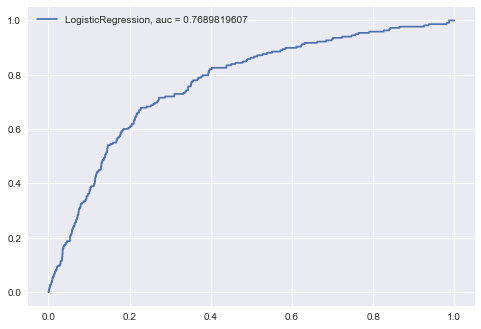

In [32]:
preds_LR = log_model.predict_proba(X= X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds_LR)
auc = metrics.roc_auc_score(y_test, preds_LR)
plt.plot(fpr, tpr, label="LogisticRegression, auc = "+ str(auc))    


plt.legend(loc=0)


Logistic regression is unable to predict any positive classes with a high precision using the default threshold of 0.5. We can try tree-based methods instead to see if we can improve on the AUC of 0.76.

In [33]:
# Setting up the stratified training (70%) and test (30%) sets on original dataframe

data = df.copy()
X = data[data.columns[:-1]]
y = data['response']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.3)

## Model Selection

In the following cells several classifier algorithms are tested, with the cross-validation accuracy output for each.

In [34]:
# Consider model options and evaluate metrics using k-folds cross-validation
num_folds = 5
num_instances = len(X_train)
seed = 42
scoring = 'recall'
models = []

models.append(('CART', DecisionTreeClassifier()))                                       # Decision Tree Classifier
models.append(('RF', RandomForestClassifier(n_estimators=500)))                         # Random Forest Classifier
models.append(('ERF', ExtraTreesClassifier(n_estimators=500)))                          # Extra Random Forest Classifier
models.append(('GB', GradientBoostingClassifier(n_estimators=500)))                     # Gradient Boosting Classifier


# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

CART: 0.255873 (0.049067)
RF: 0.246069 (0.040715)
ERF: 0.246069 (0.040715)
GB: 0.059037 (0.016349)


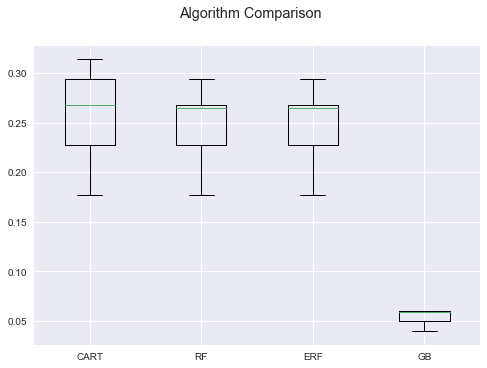

In [35]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Surprisingly, Gradient Boost does not perform well, however Random Forest and Extra Trees are good model candidates. CART is most likely overfit to the training data, Random Forest and Extra Trees will be useful to reduce any impact of variance.

Tuning the two model hyperparameters and adding class weight 

In [36]:
parameters = {'max_features':('auto', 'log2'), 'min_samples_leaf': [1, 5, 10], 'min_samples_split':[2, 10]}

ET = ExtraTreesClassifier(n_estimators = 500, random_state = 42, class_weight = 'balanced')

clf = GridSearchCV(ET, parameters, scoring='recall')
clf.fit(X_train, y_train)
clf.get_params(deep=True)
print('Best in-sample recall: {}'.format(clf.score(X_train, y_train)))
print('achieved using: {}'.format(clf.best_params_))
print('The out-of-sample recall for these parameters: {}'.format(clf.best_score_))


Best in-sample recall: 0.984251968503937
achieved using: {'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2}
The out-of-sample recall for these parameters: 0.5058362593938631


In [37]:
parameters = {'max_features':('auto', 'log2'), 'min_samples_leaf': [1, 5, 10], 'min_samples_split':[2, 10]}

RF = RandomForestClassifier(n_estimators = 500, random_state=42, class_weight = 'balanced')
clf = GridSearchCV(RF, parameters, scoring='recall')
clf.fit(X_train, y_train)
clf.get_params(deep=True)
print('Best in-sample recall: {}'.format(clf.score(X_train, y_train)))
print('achieved using: {}'.format(clf.best_params_))
print('The out-of-sample recall for these parameters: {}'.format(clf.best_score_))

Best in-sample recall: 0.9468503937007874
achieved using: {'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2}
The out-of-sample recall for these parameters: 0.3759717474283075


## Model Training and Evaluation

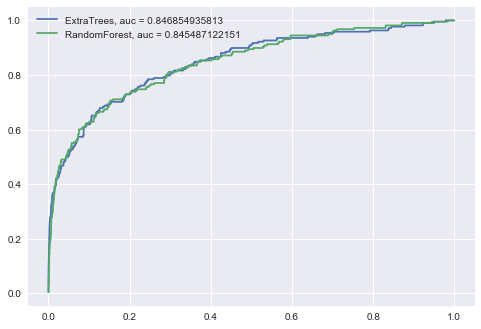

In [38]:
# Compare the Random Forest model with Extra Trees

from sklearn import metrics
import pandas as pd
from ggplot import *

plt.figure(0).clf()

# Initialize model
EF = ExtraTreesClassifier(n_estimators = 500, max_features = 'log2',
                          min_samples_leaf = 10, min_samples_split = 2, class_weight = 'balanced', random_state = 42)
# Train model
EF.fit(X = X_train ,
              y = y_train)

preds_EF = EF.predict_proba(X = X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds_EF)
auc = metrics.roc_auc_score(y_test, preds_EF)
plt.plot(fpr, tpr, label = "ExtraTrees, auc = "+ str(auc))    

# Initialize model
RF = RandomForestClassifier(n_estimators=500, max_features = 'log2', min_samples_leaf = 10,
                           min_samples_split = 2, class_weight = 'balanced', random_state = 42)

# Train the model
RF.fit(X = X_train ,
              y = y_train)
#preds_RF = RF.predict(X= X_train)

preds_RF = RF.predict_proba(X= X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds_RF)
auc = metrics.roc_auc_score(y_test, preds_RF)
plt.plot(fpr, tpr, label="RandomForest, auc = "+ str(auc))    


plt.legend(loc=0)


In [39]:
RF_pred_class = RF.predict(X=X_test)

In [40]:
# Classification report for Random Forest
print(classification_report(y_test, RF_pred_class))

             precision    recall  f1-score   support

          0       1.00      0.97      0.98     47781
          1       0.06      0.49      0.11       218

avg / total       0.99      0.96      0.98     47999



In [41]:
ET_pred_class = EF.predict(X=X_test)

In [42]:
# Classification report for Extra Trees 
print(classification_report(y_test, ET_pred_class))

             precision    recall  f1-score   support

          0       1.00      0.92      0.96     47781
          1       0.03      0.57      0.06       218

avg / total       0.99      0.91      0.95     47999



Comparing the classification report and ROC curves, we see the Random Forest classifier marginally outperforms Extra Trees with a slightly higher AUC. If we want to maximize the recall, we should use Logistic Regression, but at the cost of increasing the False Positives and decreasing AUC. Using F1-score as the metric, Random Forest has the best weighted average of precision and recall for both classes.  

[ 0.55        0.3637561   0.30258664  0.24230826  0.23066085]
[ 0.03073678  0.06631606  0.08527718  0.0925156   0.09739085]


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

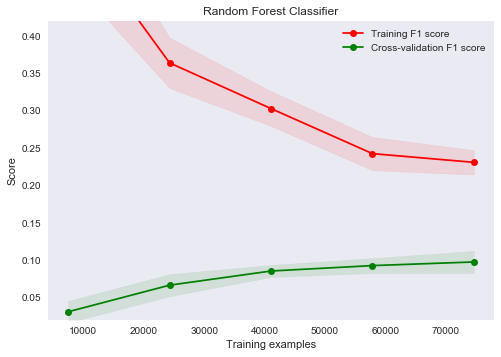

In [43]:
#Plot learning curves using sklearn's default learning curve plotting function

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    print(train_scores_mean)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print(test_scores_mean)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training F1 score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation F1 score")

    plt.legend(loc="best")
    return plt

title = "Random Forest Classifier"

estimator = RandomForestClassifier(n_estimators=500, max_features = 'log2', min_samples_leaf = 10,
                           min_samples_split = 2, class_weight = 'balanced', random_state = 42)
plot_learning_curve(estimator, title, X_train, y_train, (0.02, 0.42), n_jobs=4)


To ensure that the model isn't significantly overfitting, the learning curves are plotted. The F1 score is used as the metric since overall accuracy is highly skewed towards the majority class.

The gap between the cross-validation and training F1 score indicates that there is some amount of overfitting occuring, indicating that the model could benefit from additional data - particularly since the cross-validation F1 score is increasing with training examples. Introducing additional regularization could also reduce this overfitting.

In [44]:
rf_feature = RF.feature_importances_

In [45]:
feature_DF = pd.DataFrame( {'features': df.columns[:-1],
                         'RF_feature_importances': rf_feature})
feature_DF.sort_values(by = 'RF_feature_importances', ascending = False)

,RF_feature_importances,features
7,9.943775e-02,user_hour
0,9.044766e-02,placement
2,7.916974e-02,domain
35,7.536767e-02,placementfreq
39,7.426599e-02,os_extendedfreq
4,6.427536e-02,os_extended
36,6.376532e-02,domainfreq
5,4.524979e-02,publisher
40,4.191267e-02,publisherfreq
41,3.693750e-02,device_modelfreq


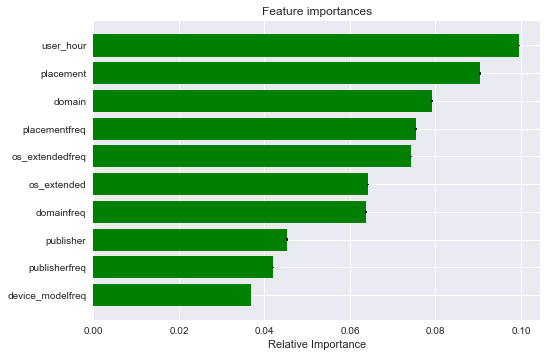

In [46]:
std = np.std([tree.feature_importances_ for tree in RF.estimators_],
             axis=0)
indices = np.argsort(rf_feature)
indices = indices[-10:]
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(len(indices)), rf_feature[indices],
       color="g", yerr=std[indices], align="center")
plt.yticks(range(len(indices)), df.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

## Make Predictions on Test data

In [47]:
test_df = pd.read_csv("test.csv")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53333 entries, 0 to 53332
Data columns (total 15 columns):
placement       53333 non-null int64
position        53333 non-null int64
browser         53333 non-null int64
carrier         53333 non-null int64
domain          46472 non-null object
supply_type     53333 non-null int64
language        53333 non-null int64
region          53333 non-null int64
os_extended     53333 non-null int64
publisher       53333 non-null int64
device_model    53333 non-null int64
device_type     53333 non-null object
user_day        53333 non-null int64
user_hour       53333 non-null int64
size            53333 non-null object
dtypes: int64(12), object(3)
memory usage: 6.1+ MB


Prepare test.csv data the same way train.csv was handled

In [48]:
test_df.loc[test_df.domain.isnull(), 'domain'] = 'Unknown_Domain'

In [49]:
test_df[labelcols] = test_df[labelcols].apply(le.fit_transform)

In [50]:
data = ['position', 'carrier', 'supply_type',  
                'region', 'user_day']
test_df[data] = test_df[data].apply(lambda x: x.astype('category'))

data = test_df[pdOHEcols]
data_dummies = pd.get_dummies(data, drop_first = True)

In [51]:
data = test_df[labelcols].join(data_dummies.ix[:,:])

In [52]:
test_df = data.copy()
test_df.head()

,placement,browser,domain,language,os_extended,publisher,device_model,user_hour,position_1,position_2,carrier_60,carrier_282,carrier_283,carrier_284,supply_type_1,supply_type_2,region_1,region_2,region_4,region_5,user_day_1,user_day_2,user_day_3,user_day_4,user_day_5,user_day_6,device_type_pc & other devices,device_type_phone,device_type_set top box,device_type_tablet,device_type_tv,size_300x250,size_300x600,size_320x50,size_728x90
0,377,7,1173,1,83,186,5,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
1,1547,6,273,0,73,378,285,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
2,1614,6,722,1,40,402,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
3,323,11,831,1,48,156,355,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
4,1547,6,273,2,62,378,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0


In [53]:
test_df['placementfreq'] = test_df.groupby('placement')['placement'].transform('count')
test_df['domainfreq'] = test_df.groupby('domain')['domain'].transform('count')
test_df['browserfreq'] = test_df.groupby('browser')['browser'].transform('count')
test_df['languagefreq'] = test_df.groupby('language')['language'].transform('count')
test_df['osfreq'] = test_df.groupby('os_extended')['os_extended'].transform('count')
test_df['publisherfreq'] = test_df.groupby('publisher')['publisher'].transform('count')
test_df['devicemodelfreq'] = test_df.groupby('device_model')['device_model'].transform('count')

In [54]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53333 entries, 0 to 53332
Data columns (total 42 columns):
placement                         53333 non-null int64
browser                           53333 non-null int64
domain                            53333 non-null int64
language                          53333 non-null int64
os_extended                       53333 non-null int64
publisher                         53333 non-null int64
device_model                      53333 non-null int64
user_hour                         53333 non-null int64
position_1                        53333 non-null uint8
position_2                        53333 non-null uint8
carrier_60                        53333 non-null uint8
carrier_282                       53333 non-null uint8
carrier_283                       53333 non-null uint8
carrier_284                       53333 non-null uint8
supply_type_1                     53333 non-null uint8
supply_type_2                     53333 non-null uint8
region_1   

In [55]:
test_preds_RF = RF.predict_proba(X= test_df)[:,1]

In [56]:
# Formatting output
test_df['Results'] = pd.Series(test_preds_RF, index=test_df.index)

In [57]:
test_df.head()
test_df.to_csv('output.csv')

,placement,browser,domain,language,os_extended,publisher,device_model,user_hour,position_1,position_2,carrier_60,carrier_282,carrier_283,carrier_284,supply_type_1,supply_type_2,region_1,region_2,region_4,region_5,user_day_1,user_day_2,user_day_3,user_day_4,user_day_5,user_day_6,device_type_pc & other devices,device_type_phone,device_type_set top box,device_type_tablet,device_type_tv,size_300x250,size_300x600,size_320x50,size_728x90,placementfreq,domainfreq,browserfreq,languagefreq,osfreq,publisherfreq,devicemodelfreq,Results
0,377,7,1173,1,83,186,5,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,81,117,8726,48491,5945,116,6777,0.047290
1,1547,6,273,0,73,378,285,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,899,899,29976,842,7564,899,701,0.032943
2,1614,6,722,1,40,402,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,38,13,29976,48491,114,83,32947,0.026580
3,323,11,831,1,48,156,355,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,12453,12677,1487,48491,4102,26175,20,0.092849
4,1547,6,273,2,62,378,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,899,899,29976,2957,3472,899,32947,0.031027


## Summary

Having tested multiple models, a random forest classifier provides the highest overall precision and recall for the positive response. 

Because random forests output feature importances, it is possible to extract which features have been most used by the model. In this case, the user hour, operating system, placement and device model make up the top features. 

For next steps, the model could be further optimized by reducing the number of features to address the overfitting seen earlier.

# Additional Questions

### A big part of a data scientist's job is to explain/summarize the research to other members of the team. Usually that involves using visualizations. Give an example of a good visualization and a bad one. Why are they good/bad? 
See example in visualization section of the python notebook. Using an incorrect y-scale can basically render a plot meaningless and unreadable. 
Another example of a bad visualization is shown below i.e. overly detailed pairplots can make it difficult to derive any insights or help interpret the data.
A nicer way of plotting feature importances is also shown below - having interactive plots significantly improves their impact and allows for rapid cycles of learning.


In [58]:
# Example of a bad visualization
badfig = sns.pairplot(df[:1000], hue="response")
badfig.savefig("bad_fig.png")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [59]:
# Example of a good visualization
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

y = feature_DF['RF_feature_importances'].values
x = feature_DF['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_DF['RF_feature_importances'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')